In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as tn
from scipy.integrate import quad
import time

# Import files
from constants import *
from pdfpy import *
from functions import  d_sigma
from rotation import *

LHAPDF 6.5.4 loading /home/ahmed/miniconda3/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


In [2]:
# Quarks
e = 0.302
quarks = [
    (2, 2/3*e, 'u', 1/2),
     #(1, -1/3*e, 'd', -1/2),
    # (3, -1/3*e, 's', -1/2),
    # (4, 2/3*e, 'c', 1/2),
    # (5, -1/3*e, 'b', -1/2),
    #  (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 4)
    g_fR = round(g_fR, 4)
    g_fL = round(g_fL, 4)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2013, -0.0449, 0.4551)]


In [3]:
#Don't foregt the metric convenction (+, -, -, -)

CL = tn.tensor([
    [0, 0, 0, 0],
    [0, 0.01, 0, 0],
    [0, 0, -0.01, 0],
    [0,0, 0, 0]
], dtype=tn.float32)

CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

C0 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)


In [4]:
# import time

# # Get the current Unix time
# current_unix_time = int(time.time())

# print(current_unix_time)
# print(start_time)

In [5]:

# p1 = 1 / np.sqrt(2) * tn.tensor([1,1, 1,1], dtype=tn.float32)

# p2 = 1 / np.sqrt(2) * tn.tensor([1,-1, -1,-1], dtype=tn.float32)

# # Initialize the variables

# # start_time = datetime.now(timezone.utc).replace(microsecond=0, second=0, minute= 0)  # Start from the beginning of the current hour
# start_time = int(time.time())
# end_time = start_time + int(timedelta(days=2).total_seconds())
# step = timedelta(hours=1)  # Step of 12 hours

# # Lists to store the times and contr matrix elements
# times = []
# contr_elementsL = []
# contr_elementsR = []

# current_time = start_time
# while current_time < end_time:
#     # Convert current_time to a timestamp
#     current_datetime = datetime.fromtimestamp(current_time)
#     time_utc = current_datetime.timestamp()
    
#     # Calculate omega_t
#     omega_t_sid = omega_utc * time_utc + 3.2830  # Example value, adjust as needed

#     # Construct the complete rotation matrix from SCF to CMS
#     R_matrix = R_y(latitude) @ R_x(azimuth) @ R_z @ R_Z(omega_t_sid)
    
#     # Compute contrL and contrR
#     contrL = np.matmul(CL, R_matrix)
#     contrR = np.matmul(CR, R_matrix)

#     # Convert contrL and contrR to PyTorch tensors
#     contrL_tensor = tn.tensor(contrL, dtype=tn.float32)
#     contrR_tensor = tn.tensor(contrR, dtype=tn.float32)
    
#     # Compute results
#     resultL = tn.dot(p1, tn.mv(contrL_tensor, p2))
#     resultR = tn.dot(p1, tn.mv(contrR_tensor, p2))

#     # Record the times and contr matrix elements
#     times.append(current_time)
#     contr_elementsL.append(contrL_tensor)
#     contr_elementsR.append(contrR_tensor)

#     # Move to the next time step
#     current_time += int(step.total_seconds())
# # Convert the list of contr elements to a NumPy array for easier indexing
# # contr_elementsL = np.array(contr_elementsL)
# # contr_elementsR = np.array(contr_elementsR)


In [6]:
# Define the constant tensors once
sqrt_half = 1 / np.sqrt(2)
p1 = sqrt_half * tn.tensor([1, 1, 1, 1], dtype=tn.float32)
p2 = sqrt_half * tn.tensor([1, -1, -1, -1], dtype=tn.float32)

# Precompute total number of steps
start_time = int(time.time())
end_time = start_time + int(timedelta(days=2).total_seconds())
step_seconds = int(timedelta(hours=1).total_seconds())
num_steps = (end_time - start_time) // step_seconds

# Lists to store the times and contr matrix elements
times = []
contr_elementsL = []
contr_elementsR = []


# Precompute parts of the rotation matrices that do not depend on omega_t_sid
R_y_lat = R_y(latitude)
R_x_azi = R_x(azimuth)

# Main loop
current_time = start_time
for _ in range(num_steps):
    # Convert current_time to a timestamp
    current_datetime = datetime.fromtimestamp(current_time)
    time_utc = current_datetime.timestamp()

    # Calculate omega_t
    omega_t_sid = omega_utc * time_utc + 3.2830  # Example value, adjust as needed

    # Construct the complete rotation matrix from SCF to CMS
    R_Z_omega = R_Z(omega_t_sid)
    R_matrix = R_y_lat @ R_x_azi @ R_Z_omega

    # Compute contrL and contrR using matrix multiplication
    contrL = np.matmul(CL, R_matrix)
    contrR = np.matmul(CR, R_matrix)

    # Convert contrL and contrR to PyTorch tensors (using in-place operations)
    contrL_tensor = tn.tensor(contrL, dtype=tn.float32).clone().detach()
    contrR_tensor = tn.tensor(contrR, dtype=tn.float32).clone().detach()

    # Compute results (using in-place operations)
    resultL = tn.dot(p1, tn.mv(contrL_tensor, p2))
    resultR = tn.dot(p1, tn.mv(contrR_tensor, p2))

    # Record the times and contr matrix elements
    times.append(current_time)
    contr_elementsL.append(contrL_tensor)
    contr_elementsR.append(contrR_tensor)

    # Move to the next time step
    current_time += step_seconds

# Convert the list of contr elements to a NumPy array for easier indexing if needed
# contr_elementsL = np.array(contr_elementsL)
# contr_elementsR = np.array(contr_elementsR)


/tmp/ipykernel_76931/2583148079.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contrL_tensor = tn.tensor(contrL, dtype=tn.float32).clone().detach()
/tmp/ipykernel_76931/2583148079.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contrR_tensor = tn.tensor(contrR, dtype=tn.float32).clone().detach()


In [7]:
# # Integration and plotting
# Q_val = np.linspace(60, 70, 50)
# a = 60 # Start of the Q range
# b = 70  # End of the Q range
# nbins = 1  # Number of bins
# # Example momenta for protons


# Q_bins = np.linspace(a, b, nbins + 1)

# # Integrate d_sigma over each bin
# # Integrate d_sigma over each bin
# results = [d_sigma(Q**2, Cc, Ch, p1, p2, 1, quark_couplings) 
#            for Cc, Ch, Q in zip(contr_elementsL, contr_elementsR, Q_val)]

# dsigma, dsigmaL, dsigmaR = zip(*results)



# def integrand(Q, CL, CR, p1, p2, n):
#     return d_sigma(Q**2,CL, CR, p1, p2, 1, quark_couplings)[0]
    
# sme_values = []
    
# for i in range(len(Q_bins) - 1):
#     Q_start = Q_bins[i]
#     Q_end = Q_bins[i + 1]
#     integral_sm, _ = quad(integrand, Q_start, Q_end, args=(C0, C0, p1, p2, 1))
#     for elemL, elemR in zip(contr_elementsL, contr_elementsR):
#             integral_sme, _ = quad(integrand, Q_start, Q_end, args=(elemR, elemL, p1, p2, 1))
#             sme_values.append(integral_sme)


In [8]:

# from multiprocessing import Pool

# # Define constants
# Q_val = np.linspace(60, 70, 50)
# a = 60  # Start of the Q range
# b = 70  # End of the Q range
# nbins = 1  # Number of bins

# # Example momenta for protons
# Q_bins = np.linspace(a, b, nbins + 1)

# # Precompute results for d_sigma
# results = [d_sigma(Q**2, Cc, Ch, p1, p2, 1, quark_couplings)
#            for Cc, Ch, Q in zip(contr_elementsL, contr_elementsR, Q_val)]
# dsigma, dsigmaL, dsigmaR = zip(*results)

# # Define the integrand function
# def integrand(Q, CL, CR, p1, p2, n, quark_couplings):
#     return d_sigma(Q**2, CL, CR, p1, p2, n, quark_couplings)[0]

# # Perform the SME integration in parallel
# def parallel_integral(args):
#     Q_start, Q_end, CL, CR, p1, p2, n, quark_couplings = args
#     integral_sme, _ = quad(integrand, Q_start, Q_end, args=(CL, CR, p1, p2, n, quark_couplings))
#     return integral_sme

# # Prepare arguments for parallel processing
# arguments = [(Q_bins[0], Q_bins[1], elemL, elemR, p1, p2, 1, quark_couplings)
#              for elemL, elemR in zip(contr_elementsL, contr_elementsR)]

# # Use a Pool to perform parallel integration
# with Pool() as pool:
#     sme_values = pool.map(parallel_integral, arguments)

# # Perform the Standard Model integration once
# Q_start = Q_bins[0]
# Q_end = Q_bins[1]
# integral_sm, _ = quad(integrand, Q_start, Q_end, args=(C0, C0, p1, p2, 1, quark_couplings))

# # integral_sm now holds the result for the Standard Model integration


In [20]:
resultssm = [d_sigma(80**2, C0, C0, p1, p2, 1, quark_couplings)]
dsigmasm, dsigmaLsm, dsigmaRsm = zip(*resultssm)

resultssme = [d_sigma(80**2, Cc, Ch, p1, p2, 1, quark_couplings)
           for Cc, Ch in zip(contr_elementsL, contr_elementsR)]
dsigmasme, dsigmaLsme, dsigmaRsme = zip(*resultssme)


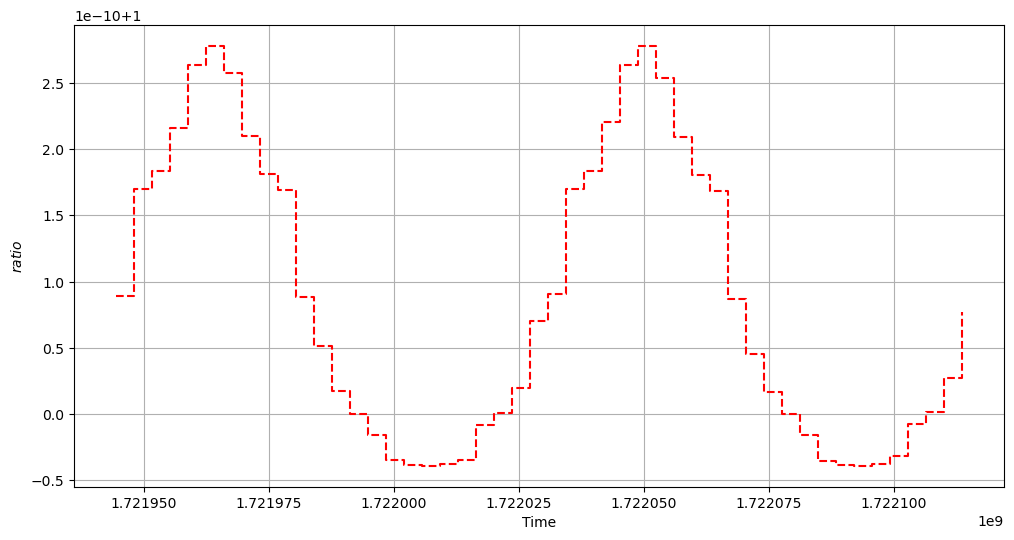

In [22]:
dratio = [t/dsigmasm[0] for t in dsigmasme]

plt.figure(figsize=(12, 6))

# Create the step plot
plt.step(times,  dratio, where='post', color='r', linestyle='--')
# plt.axhline(y=1, color='b', linestyle='-', label='y = 1')
# plt.plot(times, dsigma)
plt.xlabel('Time')
# plt.yscale('log')
plt.ylabel('$ratio$')
plt.grid('true')
# plt.title('differeintal cross section at Q=60 GeV')
# plt.savefig('intrsec.png')
plt.show()

In [28]:
print(dsigmasme)

(229772822736.77695, 229772822755.29813, 229772822758.36948, 229772822765.85605, 229772822776.79825, 229772822780.17746, 229772822775.42596, 229772822764.5797, 229772822758.01257, 229772822755.12833, 229772822736.5315, 229772822728.11374, 229772822720.23123, 229772822716.26373, 229772822712.61594, 229772822708.24103, 229772822707.44696, 229772822707.3272, 229772822707.5397, 229772822708.33023, 229772822714.42725, 229772822716.52078, 229772822720.8408, 229772822732.493, 229772822737.18832, 229772822755.3882, 229772822758.50208, 229772822766.94305, 229772822776.84848, 229772822780.12674, 229772822774.663, 229772822764.35052, 229772822757.7705, 229772822754.9558, 229772822736.26947, 229772822726.71164, 229772822720.14752, 229772822716.26245, 229772822712.5724, 229772822708.2019, 229772822707.40604, 229772822707.3273, 229772822707.5776, 229772822708.97446, 229772822714.52512, 229772822716.72195, 229772822722.62537, 229772822734.0704)


In [ ]:
Q2 = np.linspace(17.5**2, 90**2, 100)
#human_readable_times = [datetime.fromtimestamp(ts) for ts in unix_times]  # Convert to datetime objects
ratio = [t/integral_sm for t in sme_values]
filtered = [value for index, value in enumerate(ratio) if index != 11]
filtimes = [value for index, value in enumerate(times) if index != 11]
plt.figure(figsize=(12, 6))

# Create the step plot
plt.step(filtimes,  [t-1 for t in filtered], where='post', color='r', linestyle='--')
plt.axhline(y=0, color='b', linestyle='-', label='y = 1')
# plt.plot(times, dsigma)
plt.xlabel('Time')
# plt.yscale('log')
plt.ylabel('$ratio$')
plt.grid('true')
# plt.title('differeintal cross section at Q=60 GeV')
# plt.savefig('intrsec.png')
plt.show()

In [ ]:
print(np.delete(times, 24))

In [ ]:
print([t/integral_sm for t in sme_values])
print([value for index, value in enumerate(ratio) if index != 2])

In [ ]:
# import torch
# import numpy as np

# # Define the covariant tensor C_{mu nu}
# CL = torch.tensor([
#     [0, 0, 0, 0],
#     [0, 0.01, 0, 0],
#     [0, 0, -0.01, 0],
#     [0, 0, 0, 00]
# ], dtype=torch.float32)

# # Define the metric tensors g^{mu alpha} and g^{nu beta}
# # For example, using Minkowski metric with signature (+, -, -, -)
# g = torch.tensor([
#     [1, 0, 0, 0],
#     [0, -1, 0, 0],
#     [0, 0, -1, 0],
#     [0, 0, 0, -1]
# ], dtype=torch.float32)

# # Raise indices of the covariant tensor CL using the metric tensors
# # First, apply the first metric tensor to raise the first index
# temp = torch.matmul(g, CL)  # g^{mu alpha} * C_{alpha nu}

# # Then apply the second metric tensor to raise the second index
# raised_tensor = torch.matmul(temp, g)  # g^{nu beta} * temp_{alpha beta}

# print(raised_tensor)


In [ ]:
print(results)